<a href="https://colab.research.google.com/github/stepan-fukalov/ml/blob/master/finding_similar_images_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gdown
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import shutil
from pathlib import Path
from PIL import Image
from random import randrange, sample
from distutils.dir_util import copy_tree

try:
  from icecream import ic
except:
  !pip install -q icecream
  from icecream import ic

In [ ]:
url_dataset = "https://drive.google.com/file/d/1Ny40UbDAy-su-BJlYyzbGmH8ktPjeUCr/view?usp=sharing"
gdown.download(url=url_dataset,
               quiet=True,
               fuzzy=True)

url_features = "https://drive.google.com/file/d/1--4Ezv5NPeNkeULkZ9d351ihw57Qm_z7/view?usp=sharing"
gdown.download(url=url_features,
               quiet=True,
               fuzzy=True)

with zipfile.ZipFile("dataset.zip") as zip_ref:
  zip_ref.extractall("dataset")

In [ ]:
dataset_dir = "dataset/dataset"
filenames = sorted(next(iter(os.walk(dataset_dir)))[2])

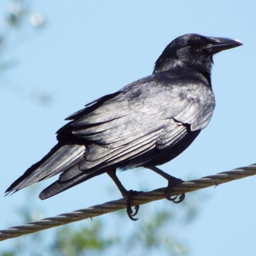

In [ ]:
from PIL import Image
Image.open("dataset/dataset/"+filenames[0])

In [ ]:
class CustomDataset(Dataset):
  def __init__(self):
    super().__init__()

  def __getitem__(self, index):
    return filenames[index]

  def __len__(self):
    return len(filenames)

dataset = CustomDataset()

dataloader = DataLoader(dataset,
            batch_size=1,
            shuffle=False)

### Extracting ResNet Features for Images

In [ ]:
! pip install transformers
from transformers import AutoImageProcessor, ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
# m = []
# for name in tqdm(dataloader):
#   image = Image.open("dataset/dataset/"+name[0]).convert(mode='RGB')
#   inputs = processor(image, return_tensors="pt")

#   with torch.no_grad():
#       logits = model(**inputs).logits

#   predicts = torch.softmax(logits, -1)
#   m.append(predicts)
# t = torch.stack(m)
t = torch.load("features.pt")

In [ ]:
pip install pyLSHash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Locality Sensitive Hashing

In [ ]:
from pyLSHash import LSHash

k = 10 # hash size
L = 5  # number of tables
d = 1000 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)
curLen = len(t)
for i in tqdm(range(curLen)):
  vec = t[i]
  img_path = filenames[i]
  lsh.index(vec.flatten(), extra_data=img_path)

  0%|          | 0/9605 [00:00<?, ?it/s]

In [ ]:
def plot_similar(filename):
  plt.figure(figsize=(5, 3))
  plt.imshow(Image.open(f"{dataset_dir}/{filename}"))
  plt.axis("off")
  plt.title(f"Target image: {filename}")
  plt.show()
  idx = int(filename.split('.')[0])

  response = lsh.query(t[idx].flatten(), num_results=9)
  fig = plt.figure(figsize=(10, 7))
  for i in range(9):
    plt.subplot(1, 9, i+1)
    plt.imshow(Image.open(f"dataset/dataset/{response[i][0][1]}"))
    plt.axis("off")
  plt.show()

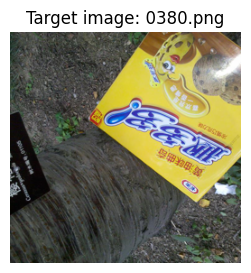

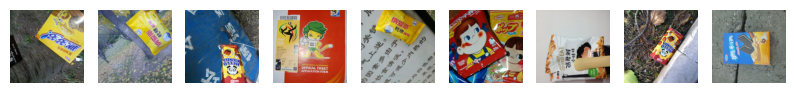

In [ ]:
plot_similar("0380.png")

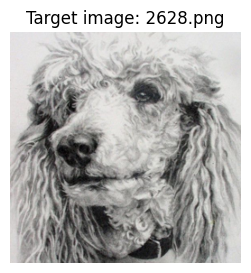

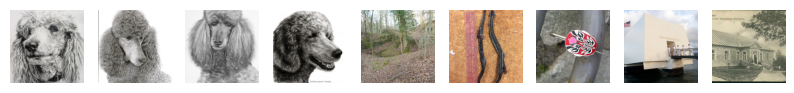

In [ ]:
plot_similar("2628.png")

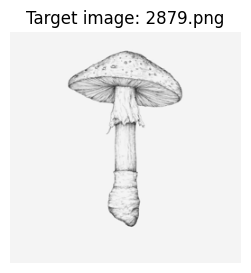

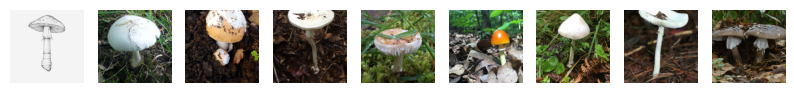

In [ ]:
plot_similar("2879.png")

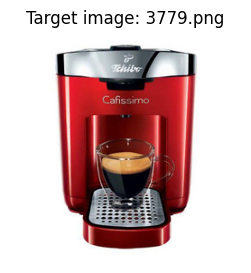

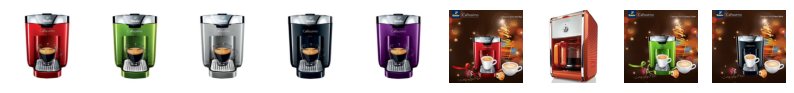

In [ ]:
plot_similar("3779.png")